# Simple music model

In [1]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider
import os
import os.path
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import pypianoroll
from pypianoroll import Multitrack, Track ### install version 0.5.2
from tqdm.notebook import tqdm
from termcolor import colored
from livelossplot import PlotLosses

In [2]:
if not torch.cuda.is_available():
    print(colored('[Warnings]', 'red'), 'GPU device not found.',
          'Please go to "Edit >> Notebook settings >> Hardware accelerator"',
          'and choose "GPU".')

[Warnings] GPU device not found. Please go to "Edit >> Notebook settings >> Hardware accelerator" and choose "GPU".


C:\logciel\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## 1. Load data

In [3]:
dataset_root = "data/lpd_5/lpd_5_cleansed/" # the root path of samples files (.npz)
id_list = [] # a list to store all file IDs of samples
for path in os.listdir("data/amg"):# the path of file which provides a list of all file IDs and the matched MSD IDs
    filepath = os.path.join("data/amg", path)
    if os.path.isfile(filepath):
        with open(filepath) as f:
            id_list.extend([(line.split(' ', 1 )[1]).strip() for line in f])
id_list = list(set(id_list))
id_list =id_list [:2000] # we took just 2000 first songs in order to reduce the size of training data and accelate the run

In [4]:
# Hyperparameters
batch_size = 32
latent_dim = 128
n_steps = 100

# Data
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100

# Sampler settings
sample_interval = 500  # interval to run the sampler (in step)
n_samples = 4

In [5]:
measure_resolution = 4 * beat_resolution
if 24 % beat_resolution > 0:
    raise ValueError("beat_resolution must be a factor of 24 (the beat "
                     "resolution used in the source dataset)")
if len(programs) != len(is_drums) or len(programs) != len(track_names):
    raise ValueError("Lengths of programs, is_drums and track_names must be "
                     "the same")

In [6]:
# method to get path of a file through file's name
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

## 2. Visulation of real music (a example)

In [7]:
song_dir = dataset_root + msd_id_to_dirs('TRQAOWZ128F93000A4') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
song_dir = song_dir.replace('\\','/')
file_path =song_dir + '/' + os.listdir(song_dir)[0]
print(file_path)

data/lpd_5/lpd_5_cleansed/Q/A/O/TRQAOWZ128F93000A4/150bba2c61dfcda9dbad5ab3b8cc00e8.npz


tracks : [Drums, Piano, Guitar, Bass, Strings],
tempo : [118.00013373 118.00013373 118.00013373 ... 115.00002875 115.00002875
 115.00002875],
downbeat : [ True False False ... False False False],
beat_resolution : 24,
name : 150bba2c61dfcda9dbad5ab3b8cc00e8


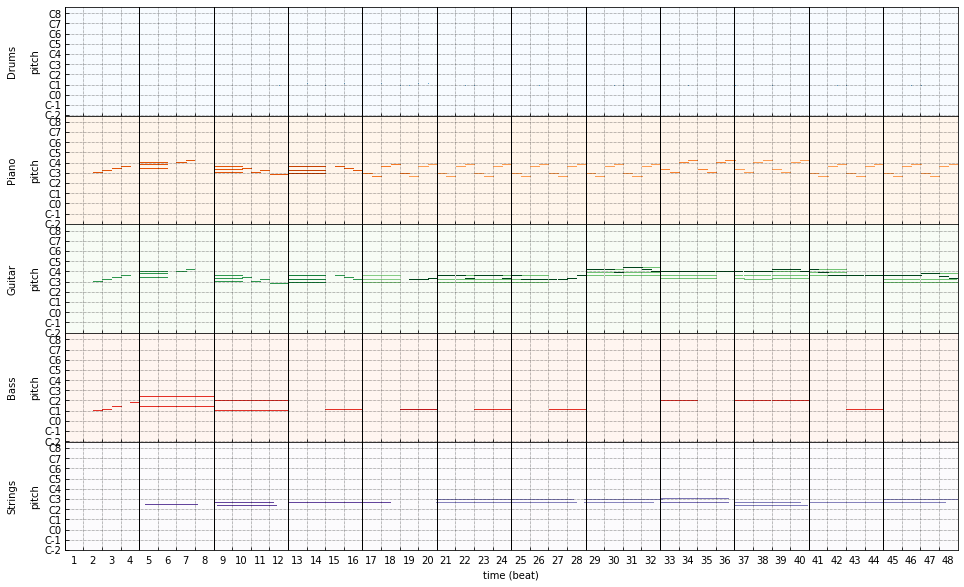

In [8]:
multitrack = Multitrack(file_path)
print(multitrack)
fig, axs = multitrack[:, :12 * 96].plot()
fig.set_size_inches((16, 10))
for ax in axs:
    for x in range(96, 12* 96, 96):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

## 3. Collect training data

In [9]:
data = []
# Iterate over all the songs in the ID list
for msd_id in id_list:
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root + msd_id_to_dirs(msd_id)
    song_dir = song_dir.replace('\\','/')
    file_path =song_dir + '/' + os.listdir(song_dir)[0]
    multitrack = Multitrack(file_path)
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.downsample(24 // beat_resolution)
    # Get the stacked pianoroll (shape: n_timesteps x n_pitches x n_tracks)
    pianoroll = multitrack.get_stacked_pianoroll()
    # Get the target pitch range only
    pianoroll = pianoroll[:, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum((0, 1)) < 10).any():
            continue
        data.append(pianoroll[start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print("Successfully collect {} samples from {} songs".format(len(data), len(id_list)))

Successfully collect 6409 samples from 2000 songs


## 4. Training data loader function

In [10]:
class MultitrackPianorollDataset(torch.utils.data.Dataset):
    """Multitrack pianoroll dataset."""
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        pianoroll = self.data[idx].astype(np.float32)
        if self.transform:
            pianoroll = self.transform(pianoroll)
        return pianoroll

class RandomTranspose():
    def __call__(self, pianoroll):
        shift = np.random.randint(12)
        return pianoroll[:, shift:n_pitches + shift]

In [11]:
def get_data_loader():
    """Download the MNIST dataset and create a data loader."""
    # Use both traning and test sets
    transform = torchvision.transforms.Compose([
        # RandomTranspose(),
        torchvision.transforms.ToTensor()])
    dataset = MultitrackPianorollDataset(data, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              drop_last=True, shuffle=True)
    return data_loader

## 5. Neural network for Generator and discriminator

In [12]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [13]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(latent_dim, 512, (4, 1, 1), (4, 1, 1)),
            torch.nn.BatchNorm3d(512),
            torch.nn.ReLU()
        )
        self.transconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(512, 256, (1, 4, 1), (1, 4, 1)),
            torch.nn.BatchNorm3d(256),
            torch.nn.ReLU()
        )
        self.transconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(256, 128, (1, 1, 4), (1, 1, 4)),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.transconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, (1, 1, 3), (1, 1, 1)),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU()
        )
        self.transconv4 = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.ConvTranspose3d(64, 16, (1, 4, 1), (1, 4, 1)),
                torch.nn.BatchNorm3d(16),
                torch.nn.Sigmoid()) for _ in range(n_tracks)])
        self.transconv5 = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.ConvTranspose3d(16, 1, (1, 1, 12), (1, 1, 12)),
                torch.nn.BatchNorm3d(1),
                torch.nn.Sigmoid()) for _ in range(n_tracks)])

    def forward(self, x):
        """
        Input:
        Output:
        """
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

In [14]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv3d(1, 16, (1, 1, 12), (1, 1, 12)),
                LayerNorm(16),
                torch.nn.LeakyReLU()) for _ in range(n_tracks)])
        self.conv1 = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv3d(16, 16, (1, 4, 1), (1, 4, 1)),
                LayerNorm(16),
                torch.nn.LeakyReLU()) for _ in range(n_tracks)])
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv3d(16 * 5, 64, (1, 1, 3), (1, 1, 1)),
            LayerNorm(64),
            torch.nn.LeakyReLU())
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 128, (1, 1, 4), (1, 1, 4)),
            LayerNorm(128),
            torch.nn.LeakyReLU())
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv3d(128, 128, (1, 4, 1), (1, 4, 1)),
            LayerNorm(128),
            torch.nn.LeakyReLU())
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv3d(128, 256, (2, 1, 1), (1, 1, 1)),
            LayerNorm(256),
            torch.nn.LeakyReLU())
        self.conv6 = torch.nn.Sequential(
            torch.nn.Conv3d(256, 512, (3, 1, 1), (3, 1, 1)),
            LayerNorm(512),
            torch.nn.LeakyReLU())
        self.dense = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)          
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 512)
        x = self.dense(x)
        return x

## 6. Training function

In [15]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=fake, create_graph=True,
                                    retain_graph=True, only_inputs=True)[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [16]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    discriminator.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    generator.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## 7. Training preparation

In [17]:
# Create data loader
data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, 
                                betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,
                                betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)


Number of parameters in G: 966655
Number of parameters in D: 582753


## 8. Training iterations

In [18]:
n_steps =100
# pour l'affichage
list_loss_G_train=[]
list_loss_D_train=[]

# Initialize step
step = 0

# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols='100%', mininterval=1)

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples)
        list_loss_G_train.append(g_loss)
        list_loss_D_train.append(d_loss)


        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            #history_samples[step] = samples

            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break



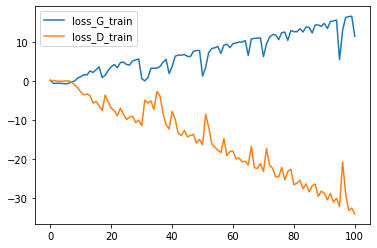

In [19]:
path_dir = os.getcwd()

# save the model of generator in ./models/
torch.save(generator,os.path.join(path_dir, "models", "generator-epoch{}.h5".format(
            n_steps)) ) 

# save the model of discriminator in ./models/
torch.save(discriminator, os.path.join(path_dir,"models", "discriminator-epoch{}.h5".format(
            n_steps)))         
x = np.array(range(len(list_loss_G_train)))
plt.plot(x, list_loss_G_train, label="loss_G_train",)
plt.plot(x, list_loss_D_train, label="loss_D_train")
plt.legend(loc="upper left")

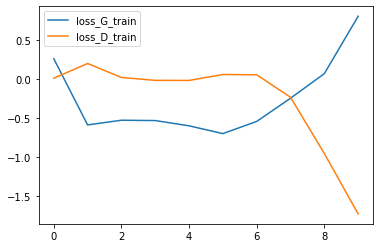

In [20]:
x = np.array(range(10))
plt.plot(x, list_loss_G_train[:10], label="loss_G_train",)
plt.plot(x, list_loss_D_train[:10], label="loss_D_train")
plt.legend(loc="upper left")

## 9. Visulation of generated music (a example)

In [ ]:
test_fake = torch.randn(10, latent_dim)
fake_samples = generator(test_fake)
fake_samples=fake_samples>0.5
print(fake_samples.shape)

test0=np.array(fake_samples[0])
print(type(test0))
tracks_name=['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']
tracks0=[]
for i in  range(5):
    pianoroll0 = (np.pad(test0[i], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)), 'constant'))
    tracks0.append(Track(name=tracks_name[i],pianoroll=pianoroll0,program=programs[i], is_drum=is_drums[i]))
m = Multitrack(tracks=tracks0, tempo=tempo, beat_resolution=beat_resolution)        

print(m)

fig, axs = m[:, :12 * 96].plot()
fig.set_size_inches((16, 10))
for ax in axs:
    for x in range(measure_resolution, 4* measure_resolution, measure_resolution):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

torch.Size([10, 5, 64, 72])
<class 'numpy.ndarray'>
tracks : [Drums, Piano, Guitar, Bass, Strings],
tempo : [100],
downbeat : None,
beat_resolution : 4,
name : unknown


In [75]:
# save the .mid file of generated music in dir ./results/ 
pm = m.to_pretty_midi(tempo)
m.write('./results/generate_music2.mid')